In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Pixel Quest: CIFAR-10 Image Classification with TensorFlow

In the world of image classification here we encounter a fascinating task of distinguishing between various objects and creatures captured in the CIFAR-10 dataset.

In the past, scientists have utilized clever filters to unveil the essence of these images. However, modern techniques have evolved, and now the finest algorithms employ the magic of linear algebra to accomplish this feat.

Lets build a few of models with increasing complexity to classify these images into one of ten classes. For simplicity and speed, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky. I do not have reference but I have read that human performance is only about 94%.


In this project, we start with the classic K-Nearest Neighbors (KNN) algorithm and gradually advance to more sophisticated models, including a neural network with a single hidden layer, a Convolutional Neural Network (CNN), and finally, the power of transfer learning using Xception.

## Getting the input data

We will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes. This is quite popular dataset and we can get it from [various links](https://www.cs.toronto.edu/~kriz/cifar.html) [online](https://www.kaggle.com/datasets/emadtolba/cifar10-comp).

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import gzip

train_images = np.load(gzip.open('train_images.npy.gz', 'rb'))
train_labels = np.load(gzip.open('train_labels.npy.gz', 'rb'))
validation_images = np.load(gzip.open('validation_images.npy.gz', 'rb'))

. npy format is the standard binary file format in NumPy for persisting a single arbitrary NumPy array

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention allows us to view the images with matplotlib:

In [4]:
train_images[0:1]

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

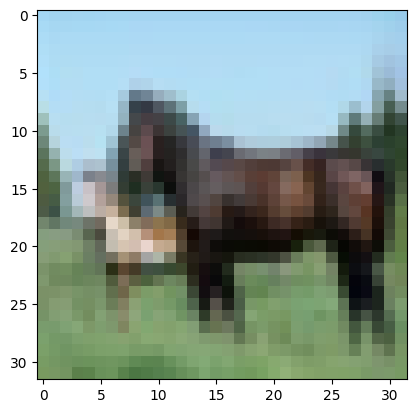

In [5]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_images[12])
plt.show()

let's savor the sight of a noble horse in a slightly blurry image, appreciating its mystique

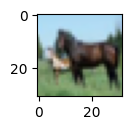

In [6]:
#if you want to see those images smaller for better clarity you can do the following
fig, axes = plt.subplots(figsize = (1.1,1.1))
axes.imshow(train_images[12,1:])
plt.show()

The human-readable names associated with this classes are :

Text(0.5, 1.0, 'Class distribution in training set')

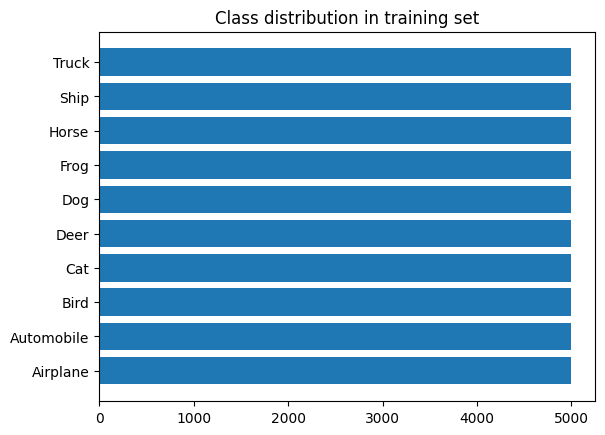

In [7]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
classes, counts = np.unique(train_labels, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

From 'airplanes' soaring through the skies to 'automobiles' speeding on the ground, from 'birds' singing melodies to 'cats' prowling gracefully, and from 'dogs' loyal as friends to 'ships' sailing the vast seas - we shall encounter a multitude of wonders!

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

## k-nearest neighbors algorithm

Our initial model is based on a simple algorithm of KNN. We shall measure the differences between colors of the corresponding pixels between two images and use this information to find the nearest companions among these images. Let's calculate a simple euclidean distance for this purpose.

$$dist = \sqrt{\Delta R^2 + \Delta G^2 + \Delta B^2} $$


In [8]:
R1 = train_images[0, :, :, 0]
#this is how you access Red
G1 = train_images[0, :, :, 1]
#this is how you access Green

B1 = train_images[0, :, :, 2]
#this is how you access Blue

print(f"shape of R1 is {R1.shape} and shape of train_images[0] is {train_images[0].shape}")

Rall = train_images[:,:,:,0]
print(f"shape of Rall is {Rall.shape}" )
# print(train_images[0])
# print(R1)
print()
#print(train_images)

shape of R1 is (32, 32) and shape of train_images[0] is (32, 32, 3)
shape of Rall is (50000, 32, 32)



In [9]:
import tensorflow as tf

@tf.function
def pixel_diff(images, base):

#   delta_R = tf.math.subtract(images[:,:,:,0], base[:,:,:,0]) #Red
#   delta_G = tf.math.subtract(images[:,:,:,1], base[:,:,:,1]) #Green
#   delta_B = tf.math.subtract(images[:,:,:,2], base[:,:,:,2]) #Blue
#   Alternate way to do this: Split the images and base into separate RGB color channels
    images_r, images_g, images_b = tf.split(images, 3, axis=-1)
    base_r, base_g, base_b = tf.split(base, 3, axis=-1)

#   Calculate the differences between the corresponding pixels in images and base for each color channel
    delta_r = images_r - base_r
    delta_g = images_g - base_g
    delta_b = images_b - base_b

    # Calculate R_mean
    #R_mean = 0.5 * (images[:,:,:,0] + base[:,:,:,0])
    R_mean = 0.5 * (images_r + base_r)

    #calculate delC for each pixel
    dist = tf.sqrt(delta_r**2 + delta_g**2 + delta_b**2 )
    avg_dist = tf.math.reduce_sum(dist, axis=(1, 2, 3))/ 1024 #32*32 is 1024

    return avg_dist

In [10]:
base = validation_images[12] # SELECTING THE BASE IMAGE AS THE HORSE
dist_all_training_img = pixel_diff(train_images, base)
indices_closest_5 = np.argsort(dist_all_training_img)[:5]

In [11]:
dist_all_training_img.shape

TensorShape([50000])

In [ ]:
indices_closest_5

Let's have a look at these 5 images which match closest with the above hourse.

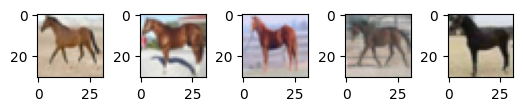

In [12]:
ax1 = plt.subplot(555)
# equivalent but more general
ax1 = plt.subplot(551)
ax1.imshow(train_images[7565,1:])

# add a subplot with no frame
ax2 = plt.subplot(552)
ax2.imshow(train_images[19064,1:])

# add a polar subplot
ax3 = plt.subplot(553)
ax3.imshow(train_images[2977,1:])

# add a red subplot that shares the x-axis with ax1
ax4 = plt.subplot(554)
ax4.imshow(train_images[27189,1:])

ax5 = plt.subplot(555)
ax5.imshow(train_images[19417,1:])


Behold! The Magic of Simplicity: Identifying an image of a Horse Without Deep Neural Networks.... This model does work pretty good but on larger dataset and for higher accuracy, we will move to deep neural networks.


## Softmax model

We'll start with a basic neural network called a softmax classifier. This network has just one dense layer that takes 32×32×3 inputs and produces 10 outputs, each representing a class. It will be using an activation function called softmax and a `CategoricalCrossentropy` loss function.

In [13]:
#Split the train dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_images,train_labels,test_size=0.2,random_state=120422)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3)
(40000,) (10000,)


In [15]:
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization,Flatten
from tensorflow.keras import backend
from tensorflow.keras import optimizers
from tensorflow.keras import losses
backend.clear_session()

model = keras.models.Sequential()

model.add(Dense(input_shape = (32,32,3), activation='relu',units = 10))
model.add(Flatten())
model.add(Dense(10,activation = 'softmax'))

adam = optimizers.Adam(learning_rate=1e-3)
model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32, 32, 10)        40        
                                                                 
 flatten (Flatten)           (None, 10240)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                102410    
                                                                 
Total params: 102,450
Trainable params: 102,450
Non-trainable params: 0
_________________________________________________________________


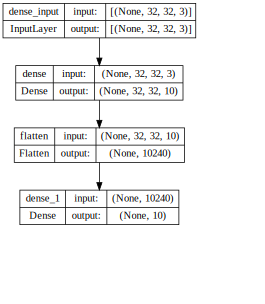

In [17]:
#Visualization of CNN architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True,show_layer_names=True,rankdir='TB').create(prog='dot',format='svg'))


In [18]:
from tensorflow.keras.utils import to_categorical as one_hot

y_train_hot = one_hot(y_train)
# y_test_hot  = one_hot(y_test)

In [19]:
history=model.fit(X_train, y_train_hot,
          validation_split=0.2,
          epochs=6,
          batch_size=10)

Epoch 1/6
3200/3200 [==============================] - 26s 8ms/step - loss: 1.8079 - accuracy: 0.3651 - val_loss: 1.7099 - val_accuracy: 0.4013
Epoch 2/6
3200/3200 [==============================] - 21s 7ms/step - loss: 1.6746 - accuracy: 0.4161 - val_loss: 1.6619 - val_accuracy: 0.4148
Epoch 3/6
3200/3200 [==============================] - 27s 8ms/step - loss: 1.6100 - accuracy: 0.4417 - val_loss: 1.6423 - val_accuracy: 0.4281
Epoch 4/6
3200/3200 [==============================] - 22s 7ms/step - loss: 1.5628 - accuracy: 0.4590 - val_loss: 1.6263 - val_accuracy: 0.4374
Epoch 5/6
3200/3200 [==============================] - 22s 7ms/step - loss: 1.5328 - accuracy: 0.4716 - val_loss: 1.6078 - val_accuracy: 0.4390
Epoch 6/6
3200/3200 [==============================] - 22s 7ms/step - loss: 1.5087 - accuracy: 0.4823 - val_loss: 1.5995 - val_accuracy: 0.4446


In [20]:
y_pred = model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


In [21]:
predicted_classes=np.argmax(y_pred,axis=1)

## Fully-connected model

Now, let's introduce a hidden layer in the hope that it will enhance our image classification capabilities.

In [22]:
from tensorflow.keras import backend
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization,Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import losses
backend.clear_session()

In [23]:
model = keras.models.Sequential()

model.add(Dense(input_shape = (32,32,3), activation='relu',units = 10))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.3)) #######this time adding dropout
model.add(Flatten())
model.add(Dense(10,activation = 'softmax'))

adam = optimizers.Adam(learning_rate=1e-3)
model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32, 32, 10)        40        
                                                                 
 dense_1 (Dense)             (None, 32, 32, 128)       1408      
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 10)                1310730   
                                                                 
Total params: 1,312,178
Trainable params: 1,312,178
Non-trainable params: 0
_________________________________________________________________


In [25]:
from tensorflow.keras.utils import to_categorical as one_hot

y_train_hot = one_hot(y_train)
# y_test_hot  = one_hot(y_test)

In [26]:
history=model.fit(X_train, y_train_hot,
          validation_split=0.2,
          epochs=10,
          batch_size=100)

Epoch 1/10
320/320 [==============================] - 149s 463ms/step - loss: 1.7195 - accuracy: 0.4054 - val_loss: 1.5702 - val_accuracy: 0.4510
Epoch 2/10
320/320 [==============================] - 158s 495ms/step - loss: 1.4855 - accuracy: 0.4850 - val_loss: 1.5073 - val_accuracy: 0.4742
Epoch 3/10
320/320 [==============================] - 148s 463ms/step - loss: 1.4222 - accuracy: 0.5077 - val_loss: 1.4784 - val_accuracy: 0.4823
Epoch 4/10
320/320 [==============================] - 149s 466ms/step - loss: 1.3686 - accuracy: 0.5305 - val_loss: 1.5004 - val_accuracy: 0.4719
Epoch 5/10
320/320 [==============================] - 151s 473ms/step - loss: 1.3316 - accuracy: 0.5396 - val_loss: 1.4654 - val_accuracy: 0.4855
Epoch 6/10
320/320 [==============================] - 162s 505ms/step - loss: 1.2856 - accuracy: 0.5580 - val_loss: 1.5039 - val_accuracy: 0.4801
Epoch 7/10
320/320 [==============================] - 148s 462ms/step - loss: 1.2576 - accuracy: 0.5673 - val_loss: 1.4935 -

As you can notice there isn't much difference in the accuracy after adding one hidden layer!

## Convolutional neural network

Now let's build our most anticipated and historically successful CNN


In [27]:
train_images_normalized = X_train.astype('float32')
validation_images_normalized = X_test.astype('float32')

# normalize to range 0-1
train_images_normalized = train_images_normalized / 255.0
validation_images_normalized = validation_images_normalized / 255.0

In [28]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

backend.clear_session()

model = keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32, 32, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(10, activation='softmax'))

opt=optimizers.Adam(learning_rate=0.001)
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                        

In [29]:
from tensorflow.keras.utils import to_categorical as one_hot
y_train_hot = one_hot(y_train)

In [30]:
history=model.fit(X_train, y_train_hot,
          validation_split=0.2,
          epochs=50,
          batch_size=128,
          callbacks=[callback],
          shuffle=True)

Epoch 1/50
250/250 [==============================] - 80s 310ms/step - loss: 1.5038 - accuracy: 0.4680 - val_loss: 4.6375 - val_accuracy: 0.1645
Epoch 2/50
250/250 [==============================] - 74s 297ms/step - loss: 1.0702 - accuracy: 0.6193 - val_loss: 2.4589 - val_accuracy: 0.3458
Epoch 3/50
250/250 [==============================] - 80s 321ms/step - loss: 0.8977 - accuracy: 0.6836 - val_loss: 1.0228 - val_accuracy: 0.6389
Epoch 4/50
250/250 [==============================] - 76s 306ms/step - loss: 0.7681 - accuracy: 0.7301 - val_loss: 0.9280 - val_accuracy: 0.6749
Epoch 5/50
250/250 [==============================] - 75s 302ms/step - loss: 0.6560 - accuracy: 0.7726 - val_loss: 1.1222 - val_accuracy: 0.6385
Epoch 6/50
250/250 [==============================] - 76s 303ms/step - loss: 0.5509 - accuracy: 0.8087 - val_loss: 1.0110 - val_accuracy: 0.6639
Epoch 7/50
250/250 [==============================] - 75s 299ms/step - loss: 0.4705 - accuracy: 0.8387 - val_loss: 1.1203 - val_ac

In [31]:
y_pred = model.predict(validation_images_normalized)
predicted_classes=np.argmax(y_pred,axis=1)

313/313 [==============================] - 7s 21ms/step


In [32]:
y_test_hot  = one_hot(y_test)
accuracy = model.evaluate(X_test, y_test_hot, verbose=2)

313/313 - 7s - loss: 1.4606 - accuracy: 0.7087 - 7s/epoch - 24ms/step


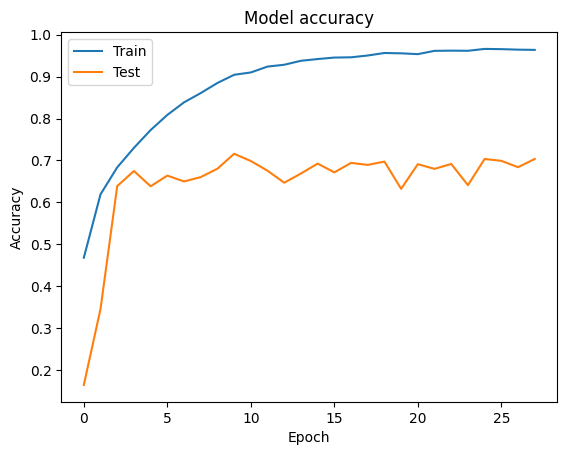

In [33]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We obtain 70% accuracy here as compared to 40% in our previous simple neural networks.
There is significant increase in accuracy with CNN :-) 🥲

## Transfer learning with Xception

Xception is the extreme version of the Inception model with depthwise separable convolutions and has been created by Google ( [Xception reference](https://https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568) ) and a combination of depthwise and pointwise convolutions. This model has outperformed VGG, Inception and Resnet in training the Imagenet dataset.

In [34]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

from tensorflow.keras.models import Model
from keras.applications.xception import Xception

#xception_model = Xception(weights='imagenet', include_top = False, input_shape = (128,128,3))
xception_model = Xception(weights='imagenet', include_top = False, input_shape = (128,128,3))
xception_model.summary()


83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [35]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in xception_model.layers:
    layer.trainable = False

In [36]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Resizing
from tensorflow.keras import backend
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization,Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import losses
backend.clear_session()
import gc

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [37]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Resizing

backend.clear_session()
transfer_learning_model = keras.models.Sequential()

transfer_learning_model.add(Resizing(128, 128, interpolation="bilinear", crop_to_aspect_ratio=False))

# Adding the convolutional part of the VGG16 model from above
transfer_learning_model.add(xception_model)
# Flattening the output of the VGG16 model because it is from a convolutional layer
transfer_learning_model.add(Flatten())

# Adding a dense output layer
transfer_learning_model.add(Dense(128, activation='relu'))
transfer_learning_model.add(BatchNormalization())
transfer_learning_model.add(Dense(32, activation='relu'))
# transfer_learning_model.add(Dropout(0.2))
transfer_learning_model.add(Dense(10, activation='softmax'))

# Compile model
transfer_learning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
transfer_learning_model.build((None,32,32,3))
transfer_learning_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                        

In [39]:
from tensorflow.keras.utils import to_categorical as one_hot

train_images_normalized = X_train.astype('float32')
validation_images_normalized = X_test.astype('float32')

# normalize to range 0-1
train_images_normalized = train_images_normalized / 255.0
validation_images_normalized = validation_images_normalized / 255.0

y_train_hot = one_hot(y_train)
# y_test_hot  = one_hot(y_test)

In [ ]:
history = transfer_learning_model.fit(X_train, y_train_hot,
          validation_split = 0.2,
          epochs = 30,
          batch_size = 30,
          callbacks = [callback])

Epoch 1/30
1067/1067 [==============================] - 3075s 3s/step - loss: 0.7484 - accuracy: 0.7489 - val_loss: 0.6493 - val_accuracy: 0.7780
Epoch 2/30
1067/1067 [==============================] - 3180s 3s/step - loss: 0.5564 - accuracy: 0.8107 - val_loss: 0.5988 - val_accuracy: 0.7920
Epoch 3/30
1067/1067 [==============================] - 3097s 3s/step - loss: 0.4661 - accuracy: 0.8384 - val_loss: 0.6091 - val_accuracy: 0.7959
Epoch 4/30
1067/1067 [==============================] - 3096s 3s/step - loss: 0.4008 - accuracy: 0.8615 - val_loss: 0.6397 - val_accuracy: 0.7899
Epoch 5/30
1067/1067 [==============================] - 3100s 3s/step - loss: 0.3421 - accuracy: 0.8818 - val_loss: 0.6494 - val_accuracy: 0.7930
Epoch 6/30
1067/1067 [==============================] - 3099s 3s/step - loss: 0.2830 - accuracy: 0.9018 - val_loss: 0.7188 - val_accuracy: 0.7849
Epoch 7/30
 746/1067 [===================>..........] - ETA: 12:12 - loss: 0.2255 - accuracy: 0.9208

Xception emerged as the clear winner with exceptional accuracy—forgive the pun, we couldn't resist! 😄

The journey allowed us to gain a comprehensive understanding of the strengths and weaknesses of each model. While KNN provided a straightforward and interpretable approach, its limitations became evident as the complexity of the task increased. The single-hidden-layer neural network showed promise but lacked the ability to capture the intricate patterns present in the images. The CNN, with its convolutional layers and feature extraction prowess, demonstrated considerable improvements over the previous models.

However, it was the Xception model, leveraging transfer learning and pretrained weights from a vast dataset, that truly set a new benchmark. Its ability to extract complex hierarchical features and generalize well to our specific classification task was the key to its exceptional accuracy.